In [150]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.optimize import minimize

We  illustrate below the principal curves methods as described in *The Elements of Statistical Learning*, by Hastie, Tibshirani, and Friedman. Specifically, we generate some bivariate data that have a nonlinear association, initializes the principal curve using the first (linear) principal component, and then computes three iterations of the algorithm described in section 14.5.2.

## Generate data

In [151]:
def gen(seed = 0):
    np.random.seed(seed)
    x1 = np.linspace(1, 10, 100)
    w = 0.6067
    a0 = 1.6345
    a1 = -0.6235
    b1 = -1.3501
    a2 = -1.1622
    b2 = -0.9443
    x2 = a0 + a1 * np.cos(x1 * w) + b1 * np.sin(x1 * w) + \
    a2 * np.cos(2 * x1 * w) + b2 * np.sin(2 * x1 * w) + np.random.normal(0, 0.75, size = len(x1))
    # Center the data
    x1 = x1 - np.mean(x1)
    x2 = x2 - np.mean(x2)
    return np.array([x1, x2]).T

In [152]:
x = gen()

In [153]:
x.shape

(100, 2)

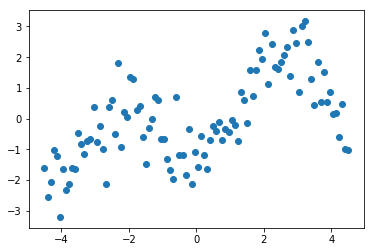

In [154]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x[:, 0], x[:, 1])
plt.show()

In [155]:
mins = np.min(x, axis = 0)
maxs = np.max(x, axis = 0)

## Initialize with first (linear) principal component

In [156]:
(u, d, vT) = np.linalg.svd(x, full_matrices=False)

In [157]:
u.shape, d.shape, vT.shape

((100, 2), (2,), (2, 2))

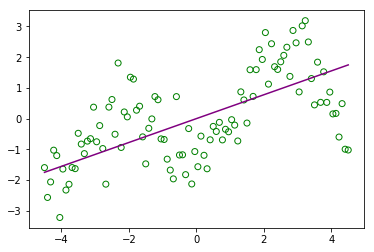

In [158]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x[:, 0], x[:, 1], marker='o', edgecolors='green', facecolors='none')
ax.plot([mins[0], 0, vT[0, 0], maxs[0]], 
        [mins[0]*vT[0, 1]/vT[0, 0], 0, vT[0, 1], maxs[0]*vT[0, 1]/vT[0, 0]], c='purple')
plt.show()

### Project data points to the line

In [159]:
projections = np.reshape(u[:, 0] * d[0], (u.shape[0], 1)) * np.reshape(vT[0, :], (1, vT.shape[0]))

In [205]:
def plot_projections(x, curve, projections):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(x[:, 0], x[:, 1], marker='o', edgecolors='green', facecolors='none')
    ax.plot(curve[:, 0], curve[:, 1], c='purple')
    # Plot the projection lines
    for i in range(projections.shape[0]):
        ax.plot([x[i, 0], projections[i, 0]], [x[i, 1], projections[i, 1]], c='red')
    return ax

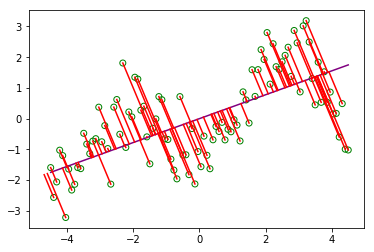

In [161]:
plot_projections(x,
                 np.array([[mins[0], 0, vT[0, 0], maxs[0]], [mins[0]*vT[0, 1]/vT[0, 0], 0, vT[0, 1], maxs[0]*vT[0, 1]/vT[0, 0]]]).T, 
                 projections)
plt.show()

## The iterative algorithm

In the step (a) of the algorithm, we need to enforce the self-consistency requirement by forcing the function value $f(\lambda)$ to be equal to the expectation (average) of all data points that have the arc length $\lambda$ on the current curve:
$$f(\lambda) = E(X | \lambda(X) = \lambda)$$
In analogy to regression, here, $\lambda$ is the feature variable, and $X$ is the response variable. Similarly, in regression, the theoretical target is also to compute the expectation (P43 in the book). However, this is just in theory. But in practice, for each continuous value $\lambda$, it is almost impossible to find many $X$ that have exactly the same arc length $\lambda$. So, we need to solve it as a regression problem (interpolation).

Here, we use scatterplot smoother (smoothing splines) to fit the observations ($\lambda_i$, $x_i$), $i = 1, \cdots, n$.

In [210]:
# Distance function to be optimized 
# when computing new lambdas (arc lengths)
def dist(lam, *args):
    (x, f1, f2) = (args[0], args[1], args[2])
    proj_1 = f1(lam)
    proj_2 = f2(lam)
    return (x[0]-proj_1)**2 + (x[1]-proj_2)**2

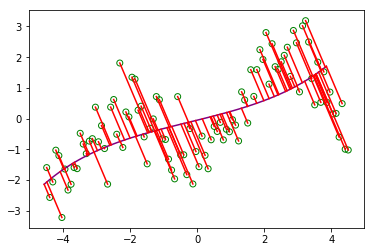

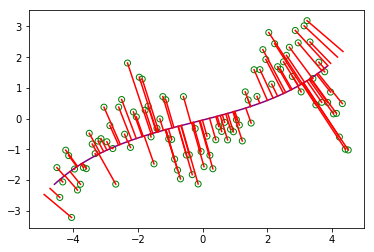

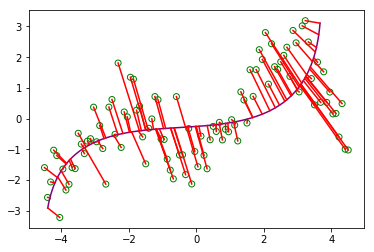

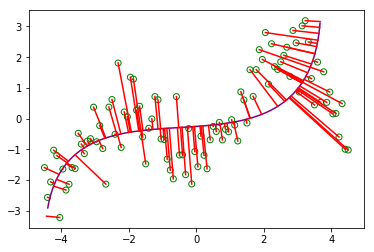

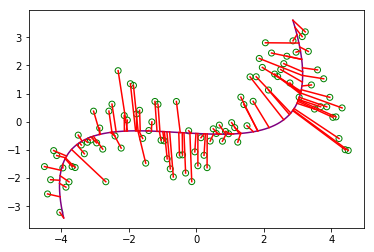

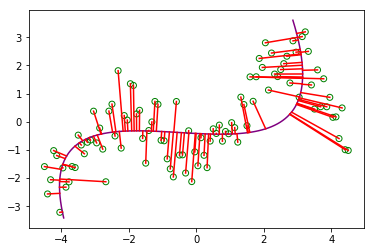

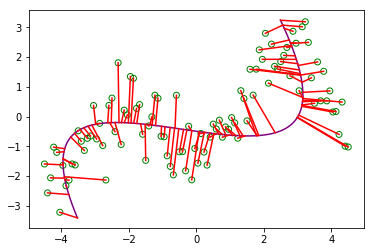

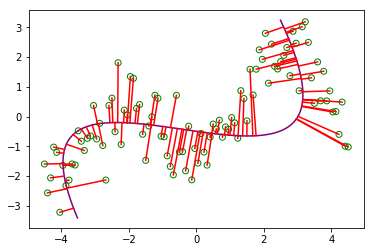

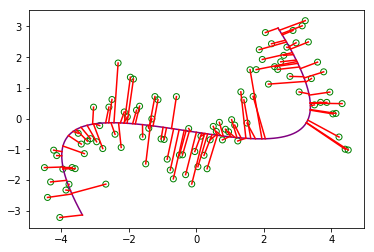

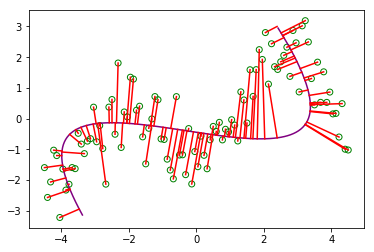

In [209]:
# Initial arc lengths on the line
lambdas = u[:, 0] * d[0]

for i in range(5):
    # Step (a)
    
    ## Compute scatterplot smoother in either dimension
    ## Scipy's UnivariateSpline requires the first array argument to be sorted in ascending order
    order = np.argsort(lambdas)
    f1 = UnivariateSpline(lambdas[order], x[:, 0][order], s = None)
    f2 = UnivariateSpline(lambdas[order], x[:, 1][order], s = None)
            
    ## Plot data and the principal curve for a sequence of lambdas
    seq_lams = np.linspace(np.min(lambdas), np.max(lambdas), 100)
    f = np.array([f1(seq_lams), f2(seq_lams)]).T
    plot_projections(x, f, np.array([f1(lambdas), f2(lambdas)]).T)
    
    
    # Step (b)
    
    ## Recompute lambdas. Use scipy's optimize function 'minimize' to
    ## find the closest point on the curve to each point
    lambdas = np.array([minimize(dist, 0, args=(point, f1, f2)).x[0] 
                           for point in x])
    plot_projections(x, f, np.array([f1(lambdas), f2(lambdas)]).T)
    
plt.show()
                           

#### Just to check what functions we have fitted

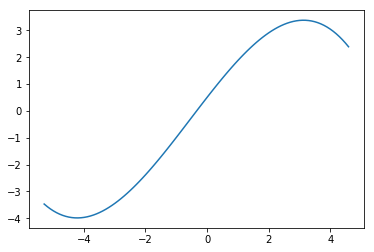

In [212]:
figure = plt.figure()
ax = figure.add_subplot(1, 1, 1)
ax.plot(seq_lams, f1(seq_lams))
plt.show()

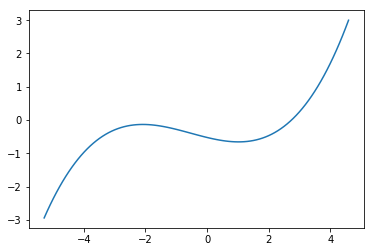

In [213]:
figure = plt.figure()
ax = figure.add_subplot(1, 1, 1)
ax.plot(seq_lams, f2(seq_lams))
plt.show()